### 기존 분야가 성범죄에서
1. 성매매
2. 성폭력/강제추행 등
3. 미성년 등 특수성범죄
4. 온라인 성범죄
\
로 나누어지는 것에 대하여 transformers의 embedding을 값을 cosine_similarity으로 나누는 작업

In [28]:
#!/usr/bin/env python
# coding: utf-8

In [2]:
import os
import sys
import warnings

import argparse

import json
import re
from glob import glob
from tqdm import tqdm
import random
import datetime
from collections import Counter
import requests

import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from umap import UMAP

import torch

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, BertConfig, AutoTokenizer, AutoModel, DistilBertTokenizer



from google.cloud import bigquery
from google.cloud import storage

warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 10)
pd.set_option('max_colwidth', -1)

In [88]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams

import seaborn as sns

path = '/usr/share/fonts/truetype/nanum/NanumMyeongjoExtraBold.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
font = fm.FontProperties(fname=path, size=9)

rcParams['figure.figsize'] = 15, 10

from plotnine import *

path = '/usr/share/fonts/truetype/nanum/NanumMyeongjoExtraBold.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
font = fm.FontProperties(fname=path, size=9)

def theme_font(figure_size = (10, 7), legend_position = "right") :
    return theme(legend_position= "right", figure_size = figure_size, text = element_text(fontproperties = font))

NanumMyeongjo
NanumMyeongjo


In [4]:
def bigquery_to_pandas(query_string) :

    credential_path = '../99_credential/lawtalk-bigquery-2bfd97cf0729.json'
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credential_path
    bqclient = bigquery.Client()
    
    b = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(
            # Optionally, explicitly request to use the BigQuery Storage API. As of
            # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
            # API is used by default.
            create_bqstorage_client=True,
        )
    )
    
    return b

In [5]:
# 참고자료 : https://huggingface.co/jhgan/ko-sroberta-multitask 에서 pytorch로 사용하는 예시가 있길래 공부차 아래 예시의 코드로 작성해보았습니다.
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [6]:
def n_idxmax(df, n = 1) :
    return df.apply(lambda x : (x.nlargest(n).index[n-1]).astype(int), axis = 1)

### 카테고리를 풀어서 매칭한 뒤 가져오기

In [7]:
query = '''
WITH c1 AS (
SELECT 
  number
  , title
  , body
  , createdAt 
  , adCategoryId
FROM `lawtalk-bigquery.raw.questions`
  , UNNEST(regexp_extract_all(categories, r"ObjectId\(\'([ㄱ-ㅎ가-힣a-zA-Z0-9 !#$%&()*+,-./:;<=>?@[\]^_`{|}~]+)\'\)")) as adCategoryId
WHERE categories != '[]'
)
, c2 AS (
  SELECT
    c1.*
    , c2.name
  FROM c1
  LEFT JOIN `lawtalk-bigquery.raw.adcategories` AS c2
  ON c1.adCategoryId = c2._id
)
SELECT * FROM c2
'''

In [8]:
df = bigquery_to_pandas(query)
print(df.name.unique())

['매매' '개인정보' '조정/화해/중재' '등기/등록' '환경' '헌법' '가압류/가처분' '공증' '조합/사단' '세금' '지역'
 '증여' '의료' '친족' '유공자/보훈' '가사기타' '국제' '소비자/집단소송' '도박' '성년후견' '지급명령' '주거침입'
 '부당이득' '아동/소년범죄' '식품/의약' '해상/항공' '언론/방송' '약식명령/즉결심판' '문서위조' '국방/병역'
 '엔터테인먼트' '도급/용역' '이민/비자' '경범죄' '체포/구속' '군형법' '마약/대마' '뇌물' '종교' '기본권'
 '정치/선거' '대국가범죄' '국민참여재판' 'IT/테크' '회생/파산' '계약일반' '공정거래' '교통사고/범죄' '금융'
 '노동/인사' '민사집행' '기타법률서비스' '보험' '건설/부동산' '상법일반' '상속' '성범죄' '위증/무고' '이혼'
 '임대차' '재산범죄' '지식재산권' '채권추심' '행정' '형사기타' '민사기타' '대여금' '손해배상' '민사소송절차' '수사'
 '형사소송절차' '명예훼손/모욕' '폭행/협박' '기업일반']


body에 있는 특수문자 등에 대한 전처리

In [9]:
reFunc1 = lambda x : re.sub(string = x, pattern = r"\n+|\t+|\{+|\}+|#+|\"+|\'+|\<+|\>+|\=+|\++|\-+|~+|\:+|\&+|\!+|\u2028+", repl = " ")
reFunc2 = lambda x : re.sub(string = x, pattern = r"\)+|\(+|-+|\.+|\s+", repl = " ")
reFunc3 = lambda x : re.sub(string = x, pattern = r"\s{2,}", repl = " ")
reFunc4 = lambda x : re.sub(string = x, pattern = "[ㄱ-ㅎㅏ-ㅣ]", repl = "")

In [10]:
df.body = df.body.apply(reFunc1)
df.body = df.body.apply(reFunc2)
df.body = df.body.apply(reFunc3)
df.body = df.body.apply(reFunc4)

In [11]:
gdf = df.groupby("number").agg(category = ("name", list), title = ("title", lambda x : np.unique(x)[0]), body = ("body", lambda x : np.unique(x)[0])).reset_index()

상담사례 다중 레이블을 이용하여 성범죄에서 재분류된 4종의 카테고리로 나눠보기

In [45]:
gdf["category"]

0         [상법일반]        
1         [환경]          
2         [환경]          
3         [환경]          
4         [기타법률서비스]     
            ...         
131308    [지식재산권]       
131309    [성범죄]         
131310    [교통사고/범죄]     
131311    [성범죄]         
131312    [성범죄, 명예훼손/모욕]
Name: category, Length: 131313, dtype: object

In [65]:
#Sentences we want sentence embeddings for

'''무료 상담에서 IT테크와 성범죄가 같이 있는 범죄는 온라인 성범죄'''
it_crime = gdf[gdf.number.isin(gdf[gdf.apply(lambda x : ("성범죄" in x["category"]) & ("IT/테크" in x["category"]), axis = 1)].number)].assign(y = "온라인성범죄")

'''아동/소년범죄와 성범죄가 같이 있는 범죄는 미성년 성범죄'''
child_crime = gdf[gdf.number.isin(gdf[gdf.apply(lambda x : ("성범죄" in x["category"]) & ("아동/소년범죄" in x["category"]), axis = 1)].number)].assign(y = "미성년성범죄")


# normal_crime = gdf[gdf.number.isin(gdf[gdf.apply(lambda x : ( x["category"] == ["성범죄"]), axis = 1)].number)]
'''성매매는 기존의 분류로 찾기 어려워 일단 성매매라는 단어가 있으면 성매매'''
trade_crime = gdf[gdf.number.isin(gdf[gdf.apply(lambda x : ("성범죄" in x["category"]) & (re.findall(string = x["body"], pattern = "성매매") != []), axis = 1)].number)].assign(y = "성매매")
# '''그 외 나머지는 성범죄일반 - 성범죄 일반에는 너무 많은 오염이 들어가있어 제외''' 
# vio_crime = gdf[gdf.number.isin(gdf[gdf.apply(lambda x : ("성범죄" in x["category"]) & ("폭행/협박" in x["category"]), axis = 1)].number)].assign(y = "성폭력")
vio_crime = gdf[gdf.number.isin(gdf[gdf.apply(lambda x : ("성범죄" in x["category"]) & (re.findall(string = x["body"], pattern = "성폭행|성폭력|성추행") != []), axis = 1)].number)].assign(y = "성폭력")

In [67]:
'''헷갈리지 않도록 네개의 카테고리 중 가장 작은 값의 샘플만 비교 - 95개?씩만 뽑아서 -> 메모리가 터져서 다시 80개로 줄임'''
sample_n = min(it_crime.shape[0], child_crime.shape[0], normal_crime.shape[0], trade_crime.shape[0], 80)
print(sample_n)

dataset = pd.concat([it_crime.sample(sample_n), child_crime.sample(sample_n), vio_crime.sample(sample_n), trade_crime.sample(sample_n)]).reset_index(drop = True)

80


In [68]:
dataset[dataset.y == "성폭력"].head(3)

number category               title  \
160  188872  [성범죄]    강제추행 기습추행 질문         
161  199540  [성범죄]    준강제추행사건 형사처벌 형량 관련   
162  156247  [성범죄]    원나잇후 신고 도와주세요        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        body  \
160  현재 이혼소송중 남편 상대로 강제추행 고소하려고합니다 현재 상대는 저를협박한 죄로 협박죄로기소되었는데요 기습추행이있을 시는 갑자기 제 머리나 얼굴 가슴 엉덩이부위를 만지고 애정표현을하며 소송취하가되었다고 안심시켰는데 그 당시 하지말라고 거부를 하였지만 너무순간적으로 하였기에 성적수치심이들고 불쾌감이들었지만 이혼을쉽게하고싶지 않아 참고 또 참고 남편을 믿었습니다 그런데 그는 소취하를 하지않앗고 부부간에 성추행죄는 성립안된다며 저에게 비아냥거렸습니다 저는 이혼을쉽게하고싶지 않았기에 남편의 기습추행에 성적수치심이 들어도참았는데 그 후 성행위도 남편을믿고 마지못해 하였습니다 그런데 계속 저를 기만하며 소취하를 하지않았습니다 대법원판례 중 기습추행을 거부하는의사를 그당시 적극적으로 경찰신고를 통해 하지못했어도 성적 수치심을 느꼈다면 충분히 가능하다고 하였는데 위에남편이말한 부부간에 성추행 성립안된다며 비아냥거리는 카톡증거와 제가 싫어 라고했더니 계속 저와살고싶다며 저를설득하는 남편의 녹취 그리고 제가 너 지금 나성추행하는거야 라고했더니 제 체온을 더 느끼고싶다하고 사랑을 더 깨달았다며 저의얼굴을 만지는내용이 녹취에있는데 제가 혼인관계 유지를위해 성적수치심이 일어났지만 강하게거부를 못했어도 강제추행 기습추행으로고소하고 처벌시킽수있을까요? 그의 의도가 정말불순합니다 답변부탁드립니다   
161  성추행을 당해 고소를 했는데 합의 요청이 있었으나 거절하고 검찰에서 구약식으로 벌금형 1000만원의 처벌이 나온 상황입니다 법원판결은 아직 안나왔는데 가해자 쪽에서 사과문과 위로금 1000만원을 주겠다며 다시 한 번 합의 요청이 왔습니다 국선 변호사가 선임되어 있는 상황인데, 변호사 말로는 합의를 하지 않아도 법원 판결에서 검찰에서 구형한 벌금보다 줄어들 것이라고 합니다 합의를 안해도 형량이 떨어지고, 합의를 해도 형량이 떨어지면 합의라도 하는게 낫지 않을까 생각이 드는데 정말로 저희가 합의를 해주지 않고 위로금을 받지 않아도 법원판결에서 형량이 많이 줄어들까요?                                                                                                                                                                                                                                                                                                                                                            
162  어플에서 만나 밖에서술을먹고 서로 좋은감정으로 머텔까지가서 술을먹게되어서 모텔비 편의점 술값 모텔에서 배달음식값까지 제가 냈습니다 그후 합의하에 성관계를맺고 새벽에 출근으로인해 제가먼저나왔습니다 물론말하고 그친구는 자고가겠다하여 서로 어플로만대화해서 어플대화내용도 지우고 연락처도없어 연락도안하다가 성폭행으로 신고되어 경찰서로 오라합니다 이경우 강간죄로 무혐의 승소하기힘든가요 또한 대처는어떻게햐야하나요                                                                                                                                                                                                                                                                                                                                                                                                                                                         

       y  
160  성폭력  
161  성폭력  
162  성폭력

In [69]:
dataset[dataset.y == "성매매"].head(3)

number      category                            title  \
240  24371   [성범죄]         성매매 단속 관련 문의                      
241  142668  [성범죄]         성매매 관련 단속 및 보이스피싱                 
242  44238   [성범죄, 폭행/협박]  6년전 일로 전 여자친구한테 성폭행 혐의로 고소당했습니다   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               body  \
240  1월쯤 오피스텔에서 성매매관련 일을 해보려고 전화도 많이해보고 면접도 보러 다녔어요 잠깐 일도 했었구요 근데 경찰쪽에서 연락이 오더니, 출석하라고 하더라구요 일단 그 업소명은 모른다고하니 위치추적결과 거기에 있던게 맞더라 라고 하면서 왜 거짓말하냐고 전화로 뭐라 하더라구요 참고인이라고 해서 오늘 출석한다고 했는데 어떻게 해야하나요 지금은 평범하게 직장생활하고있어요                                                                                                                                                                                                                                                                                                                     
241  음주하고 성욕이 너무 폭발해서 홧김에 성매매 업소에 방문하여 성매매가 아루어졌습니다 다만 이 과정에서 신분증 얼굴, 이름, 생년월일 사진과 카톡업무대화 일부를 제출하였습니다 다녀오고 나서 자괴감에 검색을 해보니, 장부에 기록이 남고 이게 단속에 의해 적발되는 경우 처벌받는 것과 이 장부에 의해 보이스피싱 등이 이루어진다고 들었습니다 지금 상황에서 제가 저 두 가지 피해를 방지하기 위해서 무엇을 할 수 있울까요? 정말로 반성하고 자괴감이 듭니다                                                                                                                                                                                                                                                                        
242  18년 1월 초쯤에 6년전 여자친구가 갑자기 6년전 일로 고소를했습니다 고소내용 제가 전 여자친구가 가출한점을 이용해서 성매매 알선을하고 첫만남에 술을먹여 겁탈을하고 성관계시 영상을녹화했고 , 유포를 한다고 협박하고, 가족들을 죽인다고 협박을 했다고합니다 성관계시 녹화한 영상을 가지고와서 국과수에 의뢰한 상태라고 합니다 위에 해당되는 사항은 전혀없고 연애할떄 합의하에 성관계를 몇번 나눈거밖엔없습니다 갑자기 6년전일로 고소를 해서 당황스럽긴했습니다 그래서 1월쯤 경찰서에가서 진술하고 조사받고 기다리고있다가 오늘 2월20일에 전화가왔습니다 담당수사관님이 거짓말탐지기를 사용해야할거같다며 동의서 작성후 해당기관으로 가서 거짓말탐지기 조사를 받아달라고 합니다 문제 될건없는데 질문 사항은 1 거짓말 탐지기를 왜 하는거죠? 증거가 없거나 그래서 그런건가요? 2 국과수에 의뢰한 영상과, 거짓말 탐지기를 해서 무혐의 판정이 나오면 전 어떻게되는거죠? 3 제가 무혐의 판단을 받으면 고소인을 무고죄로 역고소 할수있나요?   

       y  
240  성매매  
241  성매매  
242  성매매

In [70]:
dataset[dataset.y == "미성년성범죄"].head(3)

number                 category               title  \
80  133464  [아동/소년범죄, 성범죄, 명예훼손/모욕]  페이스북에 제 저격글이 올라왔는데   
81  203085  [아동/소년범죄, 성범죄]           아동복지법에 걸리나요?         
82  116760  [아동/소년범죄, 성범죄]           아동복지법에 관해 질문드립니다     

                                                                                                                                                                                                                                                                                                                                                                                                      body  \
80  고소 가능한가요? 제 친구가 제 실명을 언급하거나 하지는 않았지만 저랑 있었던 일에 대해서 글을 올렸고 그 글에 친구들이 댓글로 그냥 쌍욕은 물론 자궁 들어내도 합법이다, 걔 조건만남하면서 번돈 남자애들한테 가져다 바친다 , 창녀,걸레 라며 성희롱성 댓글들이 굉장히 많고 그 글 말고 제가 예전에 올렸던글이나 다른글들에는 제 실명을 언급하면서 욕한 댓글이 있습니다 고소가 가능한가요? 참고로 저와 욕한 친구들 모두 만 18세 즉19살입니다                                                                                                                                                    
81  제가 1n살 남자인데 볼 사람 이라고 게임 내에서 방을 만들고 들어온 여성분들과 서로의 동의하에 음란한 대화를 나누고 저의 성기를 보여줬다면 이것도 죄가 되나요? 방금 변호사님 몇 분 상담받았는데 아동복지법으로 처벌을 받을 수도 있다는 분들도 계시고 미성년자끼리 합의하에 진행한 것이라 아무 처벌을 안 받는다는 분으로 갈리네요 미성년자간에 음란한 대화도 처벌을 받을 수 있나요?                                                                                                                                                                                      
82  안녕하세요 아동복지법/아동보호법 관련 질문드립니다 남녀 사이에 정말 친하게 지내며 활발하게 연락을 주고받다 보면 어쩌다 한 번씩 자연스럽게 적당한 수위의 발언이나 장난 욕이나 야한 장난 등 을 주고받게 됩니다 이 때 이렇게 합의 하에 나눈 대화들은 법에 저촉되는 부분이 전혀 없는 걸로 알고 있습니다 하지만 만약 상대가 만 18세 미만, 즉 생일이 지나지 않은 19세라면 아동복지법/아동보호법에 저촉될 수도 있다고 알고 있습니다 그렇다면, 만약 A와 B가 연락을 주고받을 때 A가 만 18세가 넘지 않았음에도 만 18세 이상이라고 속였을 경우, 합의 하에 나눈 대화 욕이나 야한 장난 등 로 인해 B가 처벌받을 수 있나요? A는 자신이 만 18세 이상이라는 것을 여러 정황증거를 통해 입증했습니다    

         y  
80  미성년성범죄  
81  미성년성범죄  
82  미성년성범죄

In [71]:
dataset[dataset.y == "온라인성범죄"].head(3)

number               category                               title  \
0  85270   [IT/테크, 성범죄]           미성년자 동영상 판매한다면서 문상주니까 경찰서에 신고한다하네요   
1  152819  [IT/테크, 성범죄, 명예훼손/모욕]  게임내 통신매체이용음란죄 해당여부                   
2  39837   [IT/테크, 성범죄]           유튜브 폰트(윤고딕, 아리따)                     

                                                                                                                                                                                                                                                                                                                                                              body  \
0  저는 17살 이고 채팅어플을 이용해 모르는사람과 챗을 하던 도중 어떤 19살 여성분이 자기영상팔고,사진찍어주고,폰섹을 한다고 라인아이디로 들어오라길래 저도 라인아이디를 이용해 채팅방에 들어갔습니다 그리고 사기전에 그분보고 본인 확인을 위해 인증을 해달라고하니 자신의 중요부위와 가슴에 포스트잇을 붙여서 인증했습니다 그리고 다음날에 제가 동영상말고 사진을 산다고해서 그분이 저한테 원하는 자세로찍어준다고 하고 제가 문상이만원을 드리고 원하는 자세를 말했더니 아동 청소년 보호법 위반이라면서 경찰서에서 보자고 했습니다 사진은 안주고요 이행위에 제가 법적으로 문제될만한 것이 있어요?다음에 라인아이디 탈퇴했는데 신고하면 전줄 아나요?   
1  게임내에서 게임을 의도적으로 아군팀을 지게할 목적으로 악의적인 플레이를 하여 게임이 끝나고 게임캐릭터 엄마 자궁에 다시 집어넣고 싶네라고 한마디한경우 통신매체음란죄가 성립할까요? 고소는 되겠지만 기소여부가 궁금해서 상담 드립니다 그외에 욕설은 없었습니다                                                                                                                                                                                                                     
2  유튜브에 영상을 올리려하는데 윤고딕 시리즈와 아리따 시리즈를 이용하여 영상을 올려도 되나요?                                                                                                                                                                                                                                                                                                               

        y  
0  온라인성범죄  
1  온라인성범죄  
2  온라인성범죄

In [72]:
'''
모델 불러오기 
    궁금증 : KcElectra 모델로도 테스트를 해보았지만 어느정도 embedding이 될줄 알았으나 consine_similarity가 거의 다 비슷하게 나오는 현상이 있음 - 아래쪽에 참고
'''
#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained('jhgan/ko-sroberta-multitask')
model = AutoModel.from_pretrained('jhgan/ko-sroberta-multitask')
# model = AutoModel.from_pretrained("beomi/KcELECTRA-base")
# tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")

In [73]:
encoded_input = tokenizer(list(dataset.body.values), padding=True, truncation=True, max_length=512, return_tensors='pt')

# batch로 돌리지 않아서 ram이 작거나 input이 많이 들어가면 커널이 날아갈 수 있어요~
with torch.no_grad():
    model_output = model(**encoded_input)

#Perform pooling. In this case, mean pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

emb_np = sentence_embeddings.numpy()

In [74]:
train_x, test_x, train_y, test_y = train_test_split(emb_np, dataset["y"], test_size = 0.2, stratify = dataset["y"], random_state = 1)

train = dataset.iloc[train_y.index, :]
test = dataset.iloc[test_y.index, :].reset_index(drop = True)

similarity = cosine_similarity(train_x, test_x)

In [75]:
train["idxmax1"] = list(n_idxmax(pd.DataFrame(similarity), 1))
train["idxmax2"] = list(n_idxmax(pd.DataFrame(similarity), 2))
train["idxmax3"] = list(n_idxmax(pd.DataFrame(similarity), 3))

result = pd.merge(train, test[["number", "title", "body", "category", "y"]].add_suffix("_1"), left_on = "idxmax1", right_index = True)
result = pd.merge(result, test[["number", "title", "body", "category", "y"]].add_suffix("_2"), left_on = "idxmax2", right_index = True)
result = pd.merge(result, test[["number", "title", "body", "category", "y"]].add_suffix("_3"), left_on = "idxmax3", right_index = True)

In [76]:
result[["y", "y_1", "y_2", "y_3", "title", "body", "title_1", "body_1", "title_2", "body_2", "title_3", "body_3"]].to_csv("chk/chk.csv", index = False)

In [77]:
result[["y", "y_1", "y_2", "y_3"]].head()

y  y_1  y_2  y_3
256  성매매     성매매  성매매  성폭력
193  성폭력     성폭력  성매매  성폭력
294  성매매     성매매  성매매  성폭력
186  성폭력     성폭력  성폭력  성폭력
111  미성년성범죄  성매매  성매매  성폭력

### 기준 사례에 대한 제목과 본문(title, body)에 가장 유사도(코사인 유사도)가 높은 3순위에 대한 제목과 본문(title_1, body_1 ~ title_3, body_3 순서)

In [78]:
result[["y", "title", "body", "title_1", "body_1", "title_2", "body_2", "title_3", "body_3"]].head()

y                       title  \
256  성매매     출장 성매매 문의 입니다                
193  성폭력     성폭행에 대한 대처법                  
294  성매매     성매매 입금내역만으로                  
186  성폭력     성범죄로 고소당할 위기입니다 자문을 받고싶습니다   
111  미성년성범죄  미성년자 유사성행위                   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  body  \
256  얼마 전 모 호텔에서 출장성매매를 이용했습니다 호텔 유선전화를 사용해서 전화를 했고 제 전화번호나 신상정보는 넘기지 않았으며 현금사용하였습니다 여기서 궁금한건 제 핸드폰 번호는 사용하지 않았지만 CCTV / 유선통화시간 / 실장아가씨간 텔레그램 내역 / 업소장부 및 호텔 투숙객 기록으로 연계 수사하여 차후 단속 대상이 되지 않을 까 하는 걱정 입니다 답변 부탁드리겠습니다                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
193  안녕하세요 제가 소개팅하였는데 그 뒤 두번째 만남에서 둘이 술을마셨습니다 서로 호감이 있어서 여자집에 데려다 줄려고 대리를 불렀습니다 뒷자리에서 저 어깨에 잠이들어서 본의아니게 뽀뽀2번정도 및 가슴터치 1번하였습니다 그 뒤 대리를 기사가 간뒤 저한테 머라고 하던군요 제가 바로 사과를하였고 그뒤 연락이없어 이틀뒤 여자 직장에 찾아가 사과를할라고했습니다 우여곡절끝에 만나서 사과를 하였고 그때 당시 몸이안좋아 병원까지 데리다 주고 죽도 사주면서 화가 조금 풀린거 같다고 생각했습니다 그래서 카톡을 하다가 안풀려질꺼 같아면서 다신 저에게 연락하지말라고 하던군요 그래서 전혀 하지않다가 제가 술기운에 전화를 했는데 저보고 연락했다고 성폭행으로 신고한다고 문자왔습니다 여자 친동생이 전화와서 300만원에 개인합의를 하자고 하는데 어떻게 해야될지 모르겠습니다 자문요청 드리오니 변호사님 답변요청드립니다                                                                                                                                                                                                                                                                                                                         
294  아이디 못찾아서 다시 작성한겁니다 답변부탁드려요 트위터에서 조건만남보고 카톡아이디로 연락 하고 모텔 예약후 입금 상대가 준번호로 전화 50만원 보증금이라고 입금하라함 알았다한후 상대에겐 안한다함 상대도 알았다고 답함 전에 문의했었는데 성매매빙자 사기라 함 성매매 유사행위는 커녕 만나지도 않음 카톡캡쳐후 대화방나갔는데 캡쳐한거 사라짐 입금내역만으로 처벌받나요                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
186  현재 저는 21살 2년전 저보다 3살 어린 여자와 교제를 하였습니다 서로 거주지가 연애중 한번 밖에 만나지 못했습니다 그날 있던 어느정도의 스킨쉽과, 메신저 등으로 나눈 음란한 대화들이 강제적이었고, 정신적 피해로 남았다고 주장하고 있습니다 현재 고소 준비 중이라는 얘기만 들었구요 직접 만났던 날 있던 스킨쉽은 입뽀뽀였습니다 성관계에는 일절 관련된 행위가 없었습니다 직접 만났던날 이후에도 한동안 잘교제했던 사실이 있고, 다른 문제로 인한 결별 이후에도 한동안 연락을 이어나갔습니다 강제적이라는 내용에 반박할 방법이 궁금합니다 입뽀뽀라 함은 그 날 상대쪽에서도 몇번 했고, 스타트를 제가 먼저 끊었습니다 메신저 등으로 나눈 대화들에도 제가 강제적으로 그런 얘기들은 꺼낸 사실이 없고 오히려 상대방이 성적인 농담을 먼저 한 경우가 많습니다 제 친구였던 상대방의 현재 남자친구가 저를 폭행했습니다 폭행 이후 둘 사이에 어떤 언질이 오갔는지 그 사람 또한 이미 저를 성폭행범이라 주장하고 다니며 고소 준비를 돕고있습니다 현재 고소도 그 두 사람의 저를 향한 악감정에 시작됐다고 추정합니다 이 사실로 가져올수있는 유리함이 있을까요?                                                                                                                            

In [79]:
test_result1 = result.groupby("idxmax1").y.unique()
test_result2 = result.groupby("idxmax2").y.unique()
test_result3 = result.groupby("idxmax3").y.unique()

test_result = pd.concat([test_result1, test_result2, test_result3]).reset_index()
test_result = test_result.explode("y").groupby("index").agg(y_mapping = ("y", set))
test_result = pd.merge(test, pd.DataFrame(test_result), right_index = True, left_index = True)

#### 3순위까지 하면 test set 64 중 59개를 커버하고 있으므로, 커버를 못하는 사례도 있을 수 있을 것 같습니다.

In [87]:
print(test["number"].nunique())
print(result["idxmax1"].nunique())
print(result["idxmax2"].nunique())
print(result["idxmax3"].nunique())

print(len(set(result["idxmax1"].unique().tolist() + result["idxmax2"].unique().tolist() + result["idxmax3"].unique().tolist())))

64
50
53
55
59


## 최종 Test 셋에 대한 결과(y_mapping) : 개인적으로 급한 상황이라면 못 쓸 정도는 아니지 않을까 싶습니다

In [93]:
test_result.rename(columns = {"category" : "현재카테고리", "y_mapping" : "최종결과"})[["number", "현재카테고리", "title", "body", "최종결과"]].head()

number          현재카테고리                                  title  \
0  112978  [아동/소년범죄, 성범죄]  소년 재판 성범죄.                              
1  109894  [아동/소년범죄, 성범죄]  음란물 배포 신고 후                             
2  35679   [성범죄]           공연음란죄로 조서 작성했는데 초범입니다. 기소유예 가능한지..      
3  117007  [IT/테크, 성범죄]    사이버 수사팀에서 제 폰을 압수해가면 이전의 범죄도 다 들통나나요?   
4  140413  [성범죄]           성매매 미수이지만 재판에 증인으로 요청받았습니다              

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                body  \
0   정보통신망 이용 촉진 및 정보보호등에 관한 법률 위반[음란물유포죄] 성폭력 범죄의 처벌등에 관한 특례법위반[통신매체이용음란죄] 자세하게 설명 드리면, 위에 같은 사건이고, 피해자와의 합의후에 성적인 사진등을 서로 공유를 하였고 피해자가 양다리를 걸치자 상대방에게 피해자와의 저와 채팅 내용을 캡쳐를 해서 보내주었습니다 하지만 그 사진에 성기와 가슴 등 성적인 사진이 포함이 되어 있었습니다 하지만 그 성기와 가슴등 포함이 되어 있는 대화 내용을 양다리를 걸친 남자분께서 제3자에게 다시 또, 공유 한걸로 알고 있습니다 선처를 받았을 경우 최소 몇호 정도 나올까요? 정말 반성을 많이 하고 있으며, 초범입니다 정말 착하게 살아왔는데, 한순간의 잘못으로 저를 믿어 주셨던 부모님을 실망 시켜드려 정말 죄송할 따름입니다                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
1  중3올라가는 남자입니다 제가 저의 자위영상을 트위터에 여러차례 판매하고 계좌로 신고를 당했는데 형사가 부모님한테 연락하잖아요 그럼 부모님한테는 그냥 음란물 유포라고만 하나요 아니면 자위영상이라고 직접 얘기 하나요? 또 직접얘기한다면 형사가 부모님한테 제 자위영상을 보여주나요? 너무 수치심이 들고 부끄러워서 신고 후는 빨간줄 전과 찍히나요?? 진짜 너무 급해요                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2  점심경 동네 초등학교 정문 근처에 지나가면서 맞은편에 걸어오는 여학생2명이 오는걸 발견하고 충동적으로 앞 바지부분을 성기 밑 까지 내려서 노출하였습니다 이후에 그 여학생이 신고하여 경찰관들이 출동하였고 저는 사실 인정 후에 임의동행하여 지구대에서 진술서 작성했습니다 추가로 경찰관이 그 외 여죄를 물어서 기억을 더듬어 7 8월경 수십차례 위와 같이 불특정 다수 여성들을 상대로 공공장소 길거리에 맞은편에서 여성이 지나갈 때 바지를 내려서 팬티나 성기를 노출한 사실을 자백했습니다 또한 뒤 따라간 사실까지도요 뒤 따라갈 당시에 강간이나 성추행 의도는 전혀 없었으며, 상대방이 보면 보고 말면 말겠거니하고 따라간거였습니다 이 기간동안 수십차례 같은 행동을 했다고 진술했습니다 진술서에는 여학생이아니라 여성이라고 작성한 것 같습니다 그리고 8월 특정일에 다른 신고접수도 확인되었는데 확인은 못했지만 인정했습니다 위 사실 토대로 거의 비슷하게 경찰서로 인계되어 조서를 작성했으며, 앞서 말한 8월 특정일에 다른 신고건이 타 관할영역이라 그쪽에서 조사 후에 저에게 또 연락이 올 수 있으니 출석해서 조사받으라고 하더군요 그래서 하단의 궁금점을 문의드립니다 1 이미 조서작성할 때 7 8월경동안이라고 썼는데, 만약 검찰에 송치중인 상태에서 8월 특정일에 대한 타 관할서에서의 사건도 저에게 해당될 시에 추가죄로 성립되는건가요? 2 현재 관할서에서 조서를 작성했는데 타 관할서 사건과 동일인인지 여부 확인 될 때까지 담당 경찰관은 검찰에 송치안하고 기다리는건가요? 3 기소유예, 약식기소, 재판중 제가 저지른 사

In [94]:
test_result.rename(columns = {"category" : "현재카테고리", "y_mapping" : "최종결과"})[["number", "현재카테고리", "title", "body", "최종결과"]].to_csv("chk/최종결과.csv", index = False)

In [109]:
test_result.sample(5)

number        category                         title  \
60  136626  [아동/소년범죄, 성범죄]  미성년자가 아청물 구매                   
45  157250  [성범죄]           미성년 성매매 미수 질문입니다               
14  127172  [아동/소년범죄, 성범죄]  (아청법) 검색만 해도 처벌 대상이 되나요?       
27  114330  [성범죄]           아청법 음란물 소지죄에 걸렸습니다 도움이 필요합니다   
58  195900  [IT/테크, 성범죄]    통매음 관련 질문드리고싶습니다               

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  body  \
60  제가 최근에 페이스북에서 아청물을 구매했지만 소지를 하거나 시청을 하지는않았습니다 저처럼 초범인 미성년자가 아청물을 구매하면 소년보호재판을 받나요 아니면 구공판으로 넘어가나요? 그리고 제가 만약 소년보호재판을 받으면 몇호 처분을 받게될것같나요? 그리고 양형자료는 기부와 반성문을 제외하고 뭐를 준비하고 어느 정도 준비해야 하나요? 답변드리면 감사하겠습니다                                                                                                                                                                                                                                                                                                               
45  트위터 같은 sns 에서 미성년 처럼 보이는 계정에 1 1 대화로 찔러보기식으로 아무 맥락없이 스폰같은거 하시나요 혹은 스폰 하실래요 와 같이 보내면 성매매 미수인가요? 뭐 특정한 금액을 주느니 어디서 만나느니 이런거 아무것도 없이 딱 위에 말씀드린것만 해도 처벌이 되는지 궁금합니다 스폰 이란 단어가 아무 맥락없이 저런식으로 나왔으면 성관계를 내포하는것으로 해석이 되는건가요?                                                                                                                                                                                                                                                                                                  
14  정확히는 모 야동 사이트에서 성인들끼리 유치원 교사 역할놀이하는 영상의 원본을 찾기위해 구글로 여러가지 검색을 했습니다 해외 대형 야동 사이트에 원본이 있을거라 생각되었고 그 사이트 이름이 A라고 치면, 구글 검색창에 A babysitter A baby role play A 日本幼稚園 일본유치원 이런식으로 검색하였고 검색해서 뜨는 링크로 들어가 봤더니 썸네일에 어린아이처럼 보이는 영상들이 잔뜩 뜨길래 식겁해서 당연히 영상을 보지 않고 껐습니다만 영상을 시청, 소지하지 않았어도 저런식으로 검색하는 것 또한 아청법 처벌의 대상이 될 수 있는지 궁금합니다 일단 검색어가 포함된 링크로 들어간건 사실이니 불안하네요 참고로 아이피 우회는 하지 않았고 해당 사이트는 번역된 페이지를 이용해 접속하였습니다                                                                                                               
27  헤어진 동거인이 허위 성폭행 신고를 하였습니다 신고 내용중에 자신의 몸을 강압적으로 촬영했다는 피해 진술도 있어 1차 경찰조사를 받던중 수사관님께서 그당시 쓰던 폰 과 pc를 좀 봐도 되겠냐고 하시어 임의동행을 허락하고 제방에서 pc자료를 보시던중 버디셀프기타 라는 폴더에서 미성년자 음란캠동영상들이 발견되어 현장에서 체포되어 조사 받고 나왔습니다 하드디스크와 당시 쓰던 폰도 포렌식감정을 위해 압수되었습니다 해당 자료는 제가 구글에서 캠동 같은 단어를 검색하여 압축파일 형태로 토렌트로 받았습니다 당시 압축파일이었기에 안에 내용은 알수 없었지만 압축을 푼후 아동음란물이 있음에도 지우지 않은게 큰 화근이 되었습니다 평소에도 토렌트로 영화나 영상을 수집하는게 취미이긴 하지만 따로 아동음란물을 구매하거나 한적은 없습니다 현재 초범이고 잘못을 많이 반성하고 있으며 2차 조사는 아직 언제인지 모릅니다 변호사님들의 도움이 절실합니다                                      
58  안녕하세요 저는 얼마 전 에브리타임이라는 앱에서 성/고민 게시판이라는 게시판에서 어떤 여성 분이 가슴에 자꾸 털이난다 라는 식의 게시글이 였습니다 저는 여자인척을 하고 쪽지를 보냈고 그 사람과 여러 대화를 하였습니다 예를 들어 이런식 이였습니다 A를 저라고 하고 B를 여성분이라고 하겠습니다 A 난 가슴에 털 안나던데 작아서 그런가  B 나도 작아 넌 몇컵이야? 또는 B 넌 남사친있어? A 응 있지 B 파트너야 ? A 그렇지?  마지막으로 A 내 남사친 거기 성기 엄청이쁘게 생겼어  B 엥  진짜 ? A 보여줄수 있다면 보여줄텐데  B 보여줘봐  이런식으로 대화를 주고받았습니다 대화 할 때는 오히려 상대쪽이 주도하는식의 대화이기도 하였습니다 제가 상대에게 성기사진등 아무것도 요청하지 않았습니다 그런데 그분이 제가 남자인걸 아시더니 학생회에 신고를 하겠다고 하셨습니다 이럴경우 통매음이 성립되어 제가 형사처벌을 받는것도 가능할까요? 현재 에타는 모두 탈퇴한 상황입니다 너무 두렵습니다    

         y                   y_mapping  
60  미성년성범죄  {미성년성범죄}                    
45  성매매     {성매매, 온라인성범죄}               
14  미성년성범죄  {미성년성범죄, 온라인성범죄}            
27  성폭력     {성매매, 미성년성범죄, 성폭력, 온라인성범죄}  
58  온라인성범죄  {온라인성범죄, 성폭력}

In [100]:
test_result.apply(lambda x : x["y"] in x["y_mapping"], axis = 1).mean()

0.9491525423728814

In [102]:
test_result[test_result.apply(lambda x : x["y"] not in x["y_mapping"], axis = 1)]

number               category                         title  \
5   50298   [상법일반, 성범죄]            성추행 역차별                        
16  153394  [IT/테크, 성범죄, 지식재산권]    메가 아청법 관련 질문                   
53  149547  [IT/테크, 성범죄, 명예훼손/모욕]  오랜 시간이 지난 유튜브 댓글도 고소가 가능한가요?   

                                                                                                                                                                                                                                                                                                                            body  \
5   코0디 빅0그 보시면 개그우먼 들이 남자들에게 사람들을 웃기고자 뽀뽀와 몸장난을 이용해 개그소재로 이용하는 장면이 나옵니다 여성이 행동하면 장난과 그럴수도있지로 남성이 행동하면 성추행 등의 문제가 생기게 되는데 여러분들은 어떻게 생각하시나요?                                                                                                                                                                                        
16  제가 디스코드에서 스트리머 캐릭터 야짤을 판매한다길래 만원주고 샀습니다 메가 링크를 들어가자마자다운로드 그리고 미리보기가 있길래 다운로드를 했습니다 근데 다운한 사진을 보니 아동 청소년에 대한 사진이었습니다 저는 메가 다운로드를 중간에 취소를하고 바로 삭제를 했습니다 그리고 메가계정을 삭제해야되나 생각했는데 증거인멸 시도 이런것 처럼 보이나해서 3일동안 고민하다가 계정을 삭제했습니다                                                                                                        
53  안녕하세요 7년전 중학생때 수련회 장기자랑 영상을 친구가 유튜브에 올렸습니다 그후로 해당 영상에 성희롱 댓글이 달렸는데요 댓글 내용은  제이름 따먹고싶다 ,  보고 딸쳤다 등등 상당히 불쾌하고 모욕적인 성희롱 댓글이었습니다 고등학생때 해당 댓글을 발견하고 너무 놀라고 화나서 경찰서에 방문한 적이 있었는데 이런걸론 고소가 안된다 이게 무슨 성희롱이냐?는 말을 듣고와서는 포기했습니다 하지만 7년전 영상임에도 불구하고 비교적 최근인 3개월 전까지도 성희롱 댓글이 간간히 달리고 있는데요 7년전에 처음 달렸던 성희롱 댓글과 요즘 달리는 댓글까지 모두 고소할 수 있나요?   

         y y_mapping  
5   성폭력     {미성년성범죄}  
16  온라인성범죄  {미성년성범죄}  
53  온라인성범죄  {미성년성범죄}

#### 궁금증 
1. kcelectra가 embedding을 위한 모델이 아니더라도 어느 정도 문장에 대한 정보를 담아야할텐데 어떻게 이렇게 다른 성향을 나타낼까요..?
    - ko-sroberta-multitask 모델도 학습이 된 모델인데, 그렇다면 모델의 성능에 따라서 달라진다면 로톡의 데이터셋에 맞춘 모델을 대략적으로 생성한다면 Embedding에 대한 결과가 더 좋게 나올까요?

In [89]:
tokenizer = AutoTokenizer.from_pretrained('jhgan/ko-sroberta-multitask')
model = AutoModel.from_pretrained('jhgan/ko-sroberta-multitask')
# model = AutoModel.from_pretrained("beomi/KcELECTRA-base")
# tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")

#Tokenize sentences
encoded_input = tokenizer(dataset.body.values.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')

#Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

#Perform pooling. In this case, mean pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

emb_np = sentence_embeddings.numpy()

similarity = cosine_similarity(emb_np, emb_np)

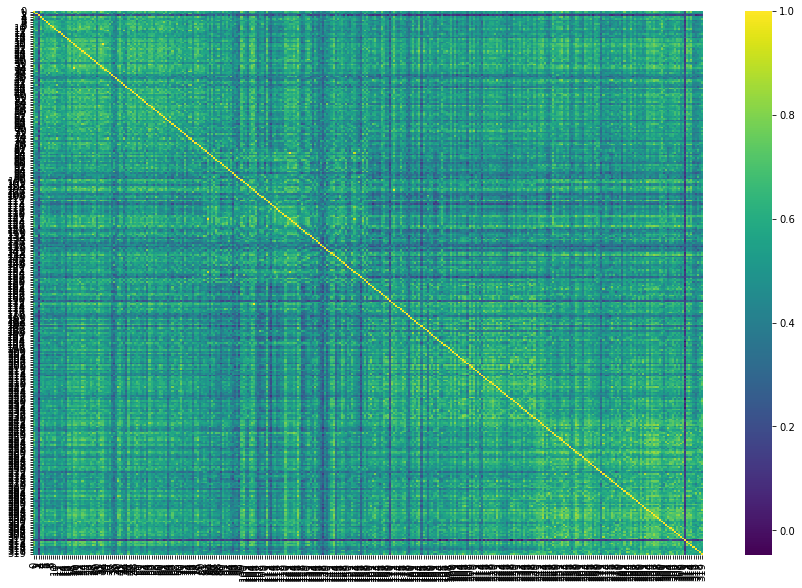

In [90]:
sns.heatmap(similarity, cmap='viridis', xticklabels = range(sample_n * 4), yticklabels = range(sample_n * 4))
plt.show()

In [91]:
# tokenizer = AutoTokenizer.from_pretrained('jhgan/ko-sroberta-multitask')
# model = AutoModel.from_pretrained('jhgan/ko-sroberta-multitask')
model = AutoModel.from_pretrained("beomi/KcELECTRA-base")
tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")

#Tokenize sentences
encoded_input = tokenizer(dataset.body.values.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')

#Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

#Perform pooling. In this case, mean pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

emb_np = sentence_embeddings.numpy()

similarity = cosine_similarity(emb_np, emb_np)

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


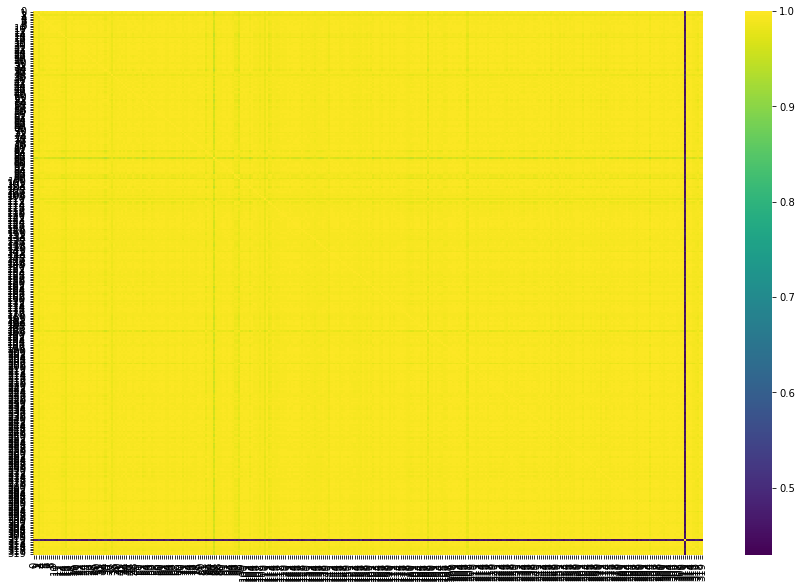

In [92]:
sns.heatmap(similarity, cmap='viridis', xticklabels = range(sample_n * 4), yticklabels = range(sample_n * 4))
plt.show()